## Run multinomial Naive Bayes on LES dataset. Examine distribution profiles. Are we making a big mistake in assuming Gaussian profiles?

In [17]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

#### Step 1: Loading data into a dataframe

In [2]:
data = pd.read_csv("data/MI_14840_2013Fall_2014Spring.csv")

In [3]:
data

,Date_CST,Time_CST,Date,Time,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),...,Skewness_lon,Skewness_lat,Kurtosis_lon,Kurtosis_lat,Sample Number,Selected,Date_UTC_y,Time_UTC_y,Lake_Visible,LES_Exist
0,20131001,00:00,2013-10-01,00:55,58,77,51,8,160,m,...,0.582646,0.007014,2.816020,1.711882,3.0,s00,20131001.0,06:00,N,N
1,20131001,01:00,2013-10-01,01:55,58,80,52,6,160,m,...,0.660357,0.030175,2.863913,1.689899,4.0,s00,20131001.0,07:00,N,N
2,20131001,02:00,2013-10-01,02:55,57,86,53,5,160,m,...,0.630409,0.023720,2.893504,1.712862,4.0,s00,20131001.0,08:00,N,N
3,20131001,03:00,2013-10-01,03:55,63,86,59,9,190,m,...,0.614300,0.024125,2.869601,1.716328,3.0,s00,20131001.0,09:00,N,N
4,20131001,04:00,2013-10-01,04:55,64,86,60,9,190,m,...,0.684025,0.192531,3.150438,1.765415,4.0,s00,20131001.0,10:00,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4364,20140331,19:00,2014-03-31,19:55,58,37,32,16,140,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4365,20140331,20:00,2014-03-31,20:55,57,38,32,14,140,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4366,20140331,21:00,2014-03-31,21:55,57,38,32,14,140,m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4367,20140331,22:00,2014-03-31,22:55,56,43,34,14,140,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Step 2: Data Cleaning

1. Dropping Nulls

In [4]:
data=data.dropna()

2. Dropping unwanted columns

In [5]:
unwanted_columns=['Date_CST','Time_CST','Peak Wind Gust(mph)', 'Low Cloud Ht (ft)', 'Med Cloud Ht (ft)',
        'High Cloud Ht (ft)','Wind Chill (F)','Heat Index (F)','Date_UTC_x','Time_UTC_x','Selected','Sample Number','Date_UTC_y'
                ,'Time_UTC_y']

In [6]:
data = data.drop(unwanted_columns, axis=1)

3. Handling 'M' and 'm' values by replacing them with 0.

In [7]:
data=data.replace('M', 0)
data=data.replace('m',0)

4. Converting features to the numeric datatype

In [8]:
features_to_numeric=['Temp (F)','RH (%)','Dewpt (F)','Wind Spd (mph)','Visibility (mi)',
                         'Wind Direction (deg)','Precip (in)','Atm Press (hPa)'    
,'Sea Lev Press (hPa)'
,'Altimeter (hPa)'    
,'Precip (in)'        
,'Mean'               
,'Centroid_lat'       
,'Std_lon'            
,'Std_lat'                  
,'Kurtosis_lon'       
,'Kurtosis_lat',       
  'Centroid_lon','Skewness_lon'       
,'Skewness_lat'                  ]

for a in features_to_numeric:
    data[a]=pd.to_numeric(data[a])

5. Creating a Snow column based on Precipitation and Temperature - if precipitation > 0.1 and temperature < 32F then Snowfall is expected and Snow would be 'Y' otherwise 'N'

In [9]:
data['Snow'] = np.where(((data['Temp (F)'] <32) & (data['Precip (in)']>0)),"Y","N")

6. Extracting month from Date since we are analysing the importance of month on snowfall.

In [10]:
data['Date']= pd.DatetimeIndex(data['Date']).month

#### Step 3: Label encoding

In [11]:
features = [ 'Time', 'Lake_Visible', 'LES_Exist','Snow']

In [12]:
label_encoder = LabelEncoder()
for col in features:
    data[col] = label_encoder.fit_transform(data[col])

In [13]:
data.dtypes

Date                      int64
Time                      int32
Temp (F)                  int64
RH (%)                    int64
Dewpt (F)                 int64
Wind Spd (mph)            int64
Wind Direction (deg)      int64
Visibility (mi)           int64
Atm Press (hPa)         float64
Sea Lev Press (hPa)     float64
Altimeter (hPa)         float64
Precip (in)             float64
Mean                    float64
Centroid_lon            float64
Centroid_lat            float64
Std_lon                 float64
Std_lat                 float64
Skewness_lon            float64
Skewness_lat            float64
Kurtosis_lon            float64
Kurtosis_lat            float64
Lake_Visible              int32
LES_Exist                 int32
Snow                      int32
dtype: object

#### Step 4: 

Analysing the plots of the each feature of the LES dataset. Since Naive Bayes is being implemented, we are checking if the features follow a normal/Gaussian distribution.

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


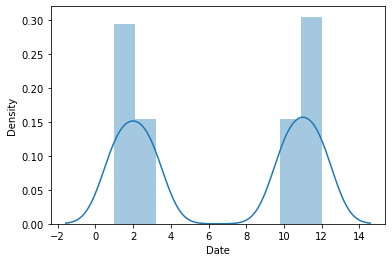

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


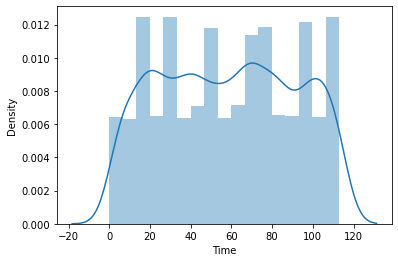

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


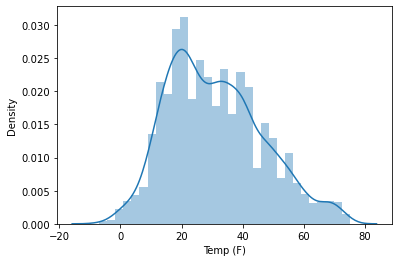

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


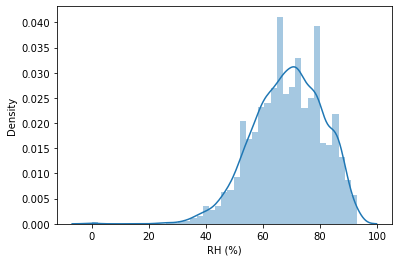

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


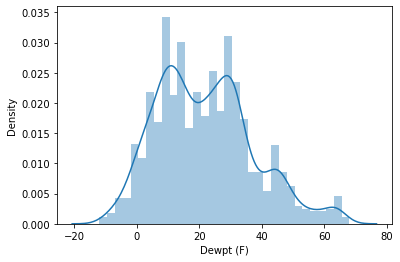

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


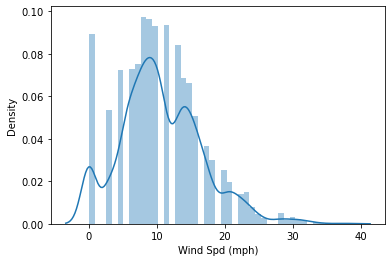

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


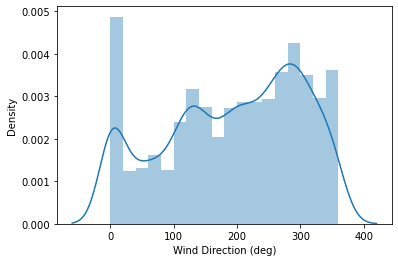

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


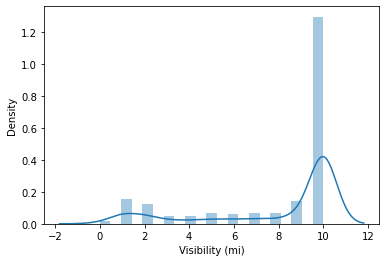

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


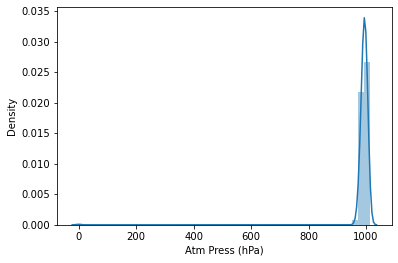

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


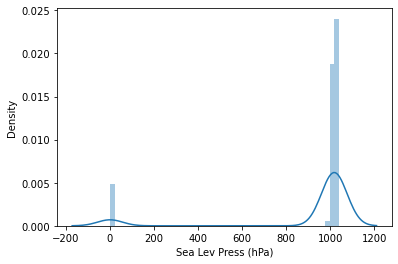

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


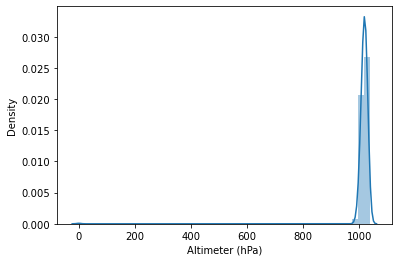

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


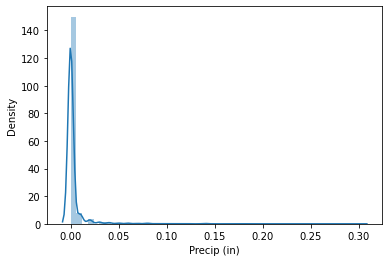

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


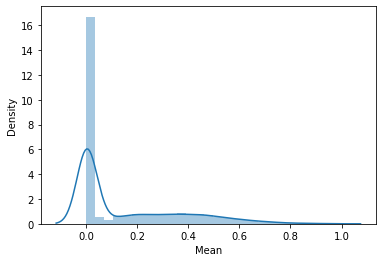

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


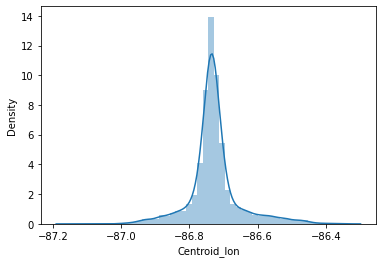

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


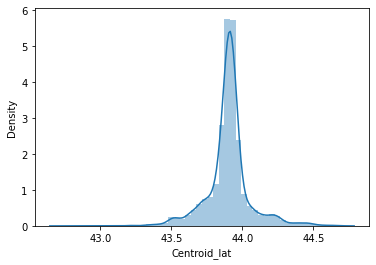

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


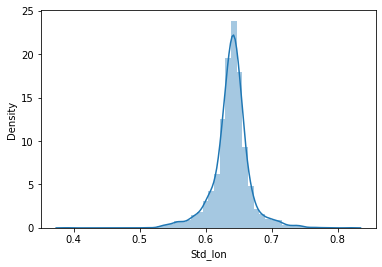

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


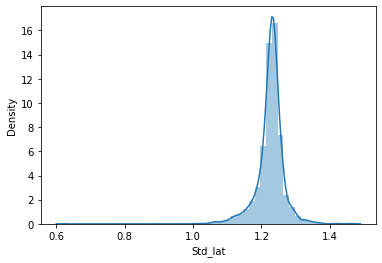

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


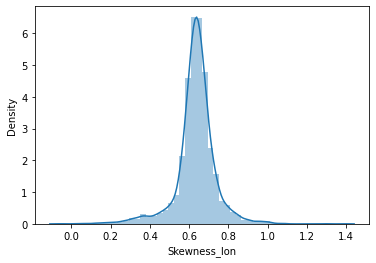

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


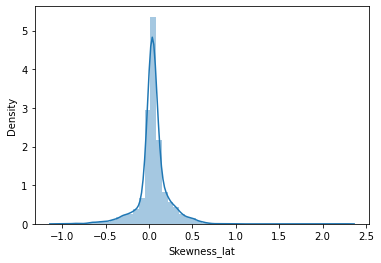

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


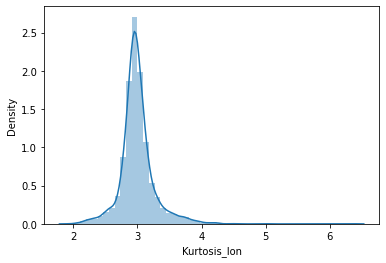

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


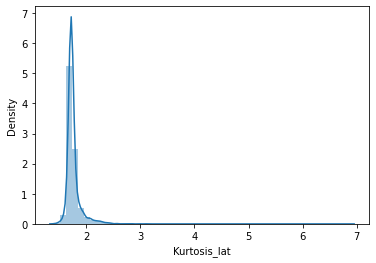

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


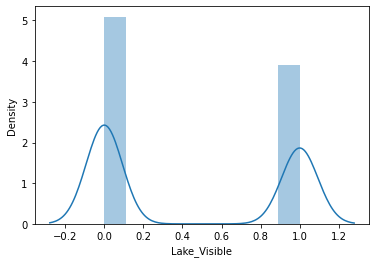

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


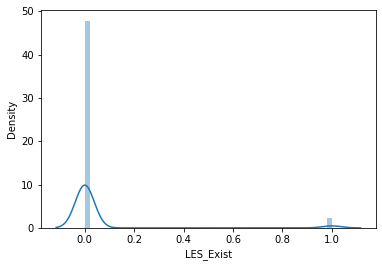

C:\Users\aleky\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


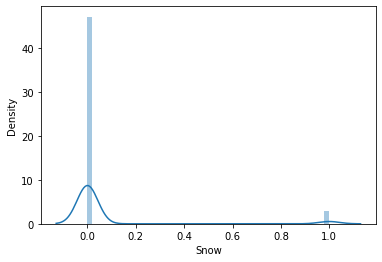

In [15]:
for feature in data:
    sns.distplot(data[feature])
    plt.show()

Clearly, the distributions are not Gaussian or normal. We are going to test if the Multnomial Naive Bayes works for this distribution. 

### Multinomial Naive Bayes

1. Assigning the target variable to y and the independent variables to X

In [16]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

2. Split data into 20% testing and 80% training sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

3. Scaling the data since the data has negative values which don't fit the multinomial Naive Bayes model

In [19]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

4. Training the multinomial naive Bayes classifier

In [20]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

5. Evaluating the model on the test data

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score

pred = nb.predict(X_test)
cm = confusion_matrix(pred, y_test)
cm

array([[716,   4],
       [101,  45]], dtype=int64)

In [22]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.9434180138568129


6. Plot the distribution profiles for each class

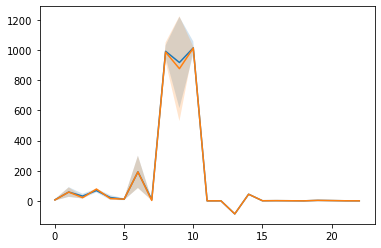

In [21]:
classes = np.unique(y)
for c in classes:
    class_idx = np.where(y == c)[0]
    class_features = X[class_idx, :]
    class_mean = np.mean(class_features, axis=0)
    class_std = np.std(class_features, axis=0)
    plt.plot(class_mean, label=c)
    plt.fill_between(np.arange(len(class_mean)), class_mean-class_std, class_mean+class_std, alpha=0.2)

plt.show()

### Conclusion:

The confusion matrix shows that there are 101 False Negatives which means that the model predicted 101 instances of snow incorrectly and only 45 instances correctly.

That is 69% of snow instances predicted incorrectly.

Thus, this model does not work for this dataset.